In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

C:\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def log(x):
    return tf.log(tf.maximum(x, 1e-6))

In [3]:
def balance_data(train_0, train_1, times):
    New_train = train_0.append(train_1, ignore_index =True)
    for i in range (times-1):
        New_train = New_train.append(train_1, ignore_index =True)
    New_train = New_train.sample(frac=1).reset_index(drop=True)
    return New_train

In [4]:
train = pd.read_csv('input/train.csv',na_values=-1)
test = pd.read_csv('input/test.csv',na_values=-1)

In [5]:
def OHE(df1,column):
    cat_col = column
    c2,c3 = [],{}
    
    print('Categorical feature',len(column))
    for c in cat_col:
        if df1[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df1, prefix=c3, columns=c2,drop_first=True)
    print('Train',df.shape)
    return df

In [6]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [7]:
def category_type(df):
    tot_cat=[]
    col = df.columns
    for i in col:
        if df[i].nunique()<=104:
            if(df[i].name!='target'):
                tot_cat.append(df[i].name)
    return tot_cat

In [8]:
missing_value(train)

In [9]:
cat_col = [col for col in train.columns if '_cat' in col]
bin_col = [col for col in train.columns if 'bin' in col]

In [10]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal,axis =1)

In [11]:
tot_cat_col = category_type(train)

In [12]:
num_col = [c for c in train.columns if c not in tot_cat_col]
num_col.remove('id')
num_col.remove('target')

In [13]:
train1 = OHE(train,tot_cat_col)

Categorical feature 33
Train (595212, 257)


In [14]:
train1 = train1.drop(['id'],axis=1)

In [15]:
train1[num_col] = StandardScaler().fit_transform(train1[num_col])

In [16]:
def change64to32(df):
    for col in df.columns:
        if(df[col].dtype==np.int64):
            df[col] = df[col].astype(np.int32)
        if(df[col].dtype==np.float64):
            df[col] = df[col].astype(np.float32)

In [17]:
change64to32(train1)

In [18]:
train70, train30 = train_test_split(train1,test_size=0.3,random_state=192)

In [19]:
train30.memory_usage(index=True).sum()

58926120

In [20]:
with tf.name_scope('layer1'):
    #x = tf.placeholder(tf.float32, [None, 255])
    validation = tf.placeholder(shape=(), dtype=tf.int32)
    inputx = tf.constant(train70.drop('target',axis=1).values, dtype=tf.float32)
    inputx_valid = tf.constant(train30.drop('target',axis=1).values, dtype=tf.float32)
    x = tf.cond(tf.equal(validation,0), lambda: inputx, lambda: inputx_valid)
    W1 = tf.Variable(tf.truncated_normal([255, 300]))
    b1 = tf.Variable(tf.zeros([300]))
    y1 = tf.tanh(tf.matmul(x, W1)+b1)
with tf.name_scope('layer2'):
    W2 = tf.Variable(tf.truncated_normal([300, 50]))
    b2 = tf.Variable(tf.zeros([50]))
    y2 = tf.tanh(tf.matmul(y1, W2)+b2)
with tf.name_scope('layerout'):
    Wout = tf.Variable(tf.truncated_normal([50, 1]))
    bout = tf.Variable(tf.zeros([1]))
    y = tf.sigmoid(tf.matmul(y2, Wout)+bout)
    #y_ = tf.placeholder(tf.float32, [None, 1])
    output = tf.constant(train70['target'].values.reshape(train70.shape[0],1), dtype=tf.float32)
    output_valid = tf.constant(train30['target'].values.reshape(train30.shape[0],1), dtype=tf.float32)
    y_ = tf.cond(tf.equal(validation,0), lambda: output, lambda: output_valid)

In [27]:
with tf.name_scope('loss'):
    cross_entropy = -tf.reduce_mean(y_*log(y)+(1-y_)*log(1-y))
    l2=tf.nn.l2_loss(Wout)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)
    l1=tf.reduce_sum(tf.abs(Wout))+tf.reduce_sum(tf.abs(W1))+tf.reduce_sum(tf.abs(W2))

    regularized_loss = cross_entropy +0.0008*l2#+0.001*l1
    train_step = tf.train.AdamOptimizer(0.005).minimize(regularized_loss)

In [28]:
with tf.name_scope('accuracy'):
    accuracy_op = tf.metrics.auc(y_,y)

39
0.630499


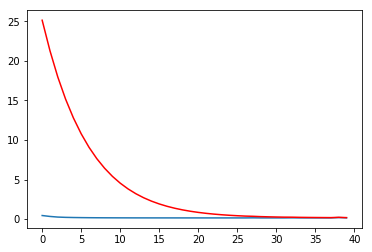

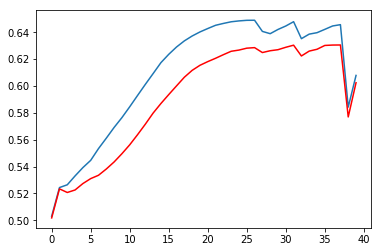

In [29]:
losses=[]
losses_reg=[]
aucs_train=[]
aucs_test=[]
train_1=train70[train70.target==1]
train_0=train70[train70.target==0]
xvl = train30.drop('target',axis=1)
yvl = train30['target'].values.reshape(train30.shape[0],1)
batch_ys = train70['target'].values.reshape(train70.shape[0],1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for j in range(40):
        for i in range(20): 
            #train_batch01 = train_1.append(train_0.sample(frac=0.05), ignore_index =True)
            #train_batch01 = train_batch.sample(frac=0.05)
            #batch_xs = train_batch01.drop('target',axis=1)
            
            _,loss_reg, loss = sess.run([train_step,regularized_loss, cross_entropy], feed_dict={validation:0})
        clear_output()
        print(j)
        losses.append(loss)
        losses_reg.append(loss_reg)
        sess.run(tf.local_variables_initializer())
        auc_test = sess.run(accuracy_op,feed_dict={validation:1})
        aucs_test.append(auc_test[1])        
        sess.run(tf.local_variables_initializer())
        auc_train = sess.run(accuracy_op,feed_dict={validation:0})
        aucs_train.append(auc_train[1])


print(max(aucs_test))
plt.plot(losses)
plt.plot(losses_reg,"r-")
plt.show()
plt.plot(aucs_train,)
plt.plot(aucs_test,"r-")
plt.show()